In [7]:
import logging
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from icecream import ic

Cost: $d + (d \cdot \alpha \cdot w)^\beta$ with $\alpha \ge 0$ and $\beta \ge 0$

In [8]:
class Problem:
    _graph: nx.Graph
    _alpha: float
    _beta: float

    def __init__(
        self,
        num_cities: int,
        *,
        alpha: float = 1.0,
        beta: float = 1.0,
        density: float = 0.5,
        seed: int = 42,
    ):
        rng = np.random.default_rng(seed)
        self._alpha = alpha
        self._beta = beta
        cities = rng.random(size=(num_cities, 2))
        cities[0, 0] = cities[0, 1] = 0.5

        self._graph = nx.Graph()
        self._graph.add_node(0, pos=(cities[0, 0], cities[0, 1]), gold=0)
        for c in range(1, num_cities):
            self._graph.add_node(c, pos=(cities[c, 0], cities[c, 1]), gold=(1 + 999 * rng.random()))

        tmp = cities[:, np.newaxis, :] - cities[np.newaxis, :, :]
        d = np.sqrt(np.sum(np.square(tmp), axis=-1))
        for c1, c2 in combinations(range(num_cities), 2):
            if rng.random() < density or c2 == c1 + 1:
                self._graph.add_edge(c1, c2, dist=d[c1, c2])

        assert nx.is_connected(self._graph)

    @property
    def graph(self) -> nx.Graph:
        return nx.Graph(self._graph)

    @property
    def alpha(self):
        return self._alpha

    @property
    def beta(self):
        return self._beta

    def cost(self, path, weight):
        dist = nx.path_weight(self._graph, path, weight='dist')
        return dist + (self._alpha * dist * weight) ** self._beta

    def baseline(self):
        cost = 0
        for dest, path in nx.single_source_dijkstra_path(
            self._graph, source=0, weight='weight'
        ).items():
            if dest == 0:
                continue
            logging.debug(
                f"dummy_solution: go to {dest} ({' > '.join(str(n) for n in path)}) -- cost: {self.cost(path, 0):.2f}"
            )
            logging.debug(f"dummy_solution: grab {self._graph.nodes[dest]['gold']:.2f}kg of gold")
            logging.debug(
                f"dummy_solution: return to 0 ({' > '.join(str(n) for n in reversed(path))}) -- cost: {self.cost(path, self._graph.nodes[dest]['gold']):.2f}"
            )
            cost += self.cost(path, 0) + self.cost(path, self._graph.nodes[dest]['gold'])
        logging.info(f"dummy_solution: total cost: {cost:.2f}")
        return cost

    def plot(self):
        plt.figure(figsize=(10, 10))
        pos = nx.get_node_attributes(self._graph, 'pos')
        size = [100] + [self._graph.nodes[n]['gold'] for n in range(1, len(self._graph))]
        color = ['red'] + ['lightblue'] * (len(self._graph) - 1)
        return nx.draw(self._graph, pos, with_labels=True, node_color=color, node_size=size)

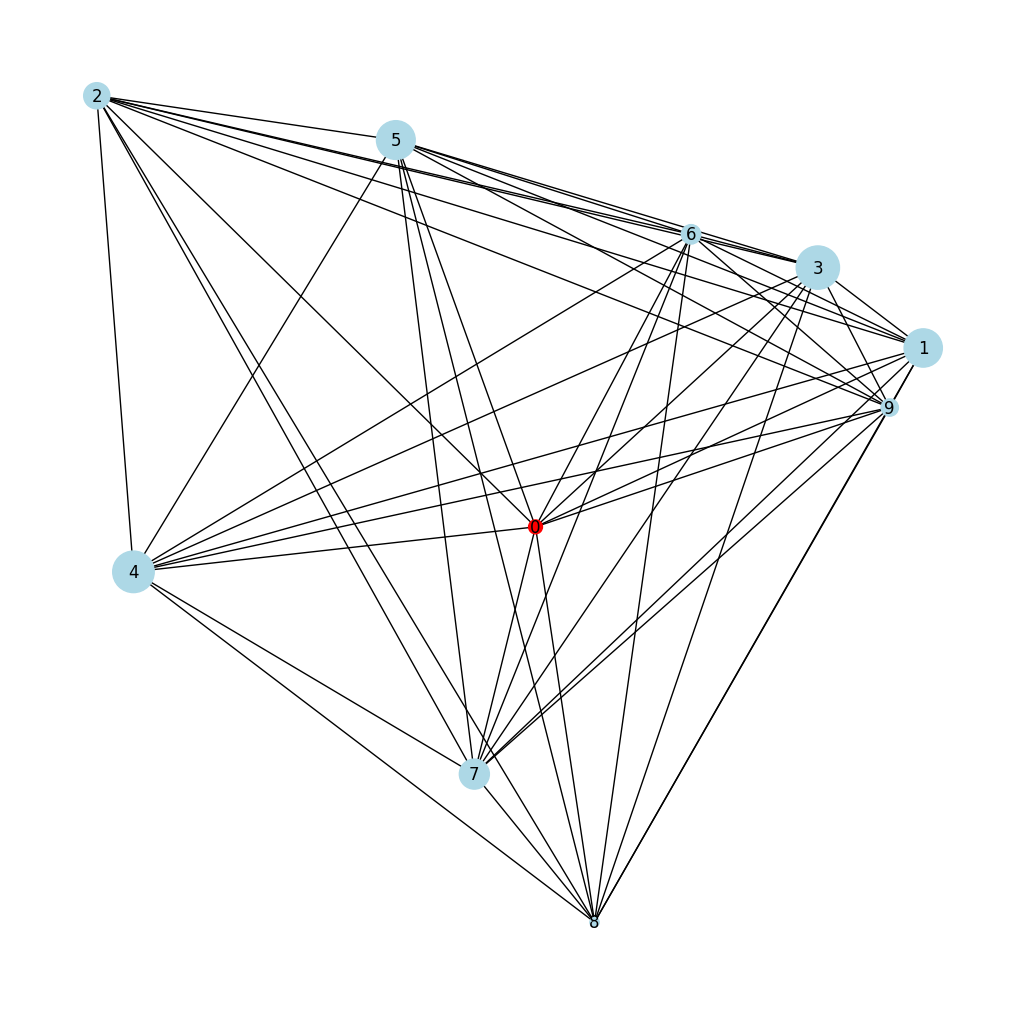

In [9]:
P = Problem(10, density=1, alpha=2, beta=1)
P.plot()

In [10]:
P.graph.nodes[9]

{'pos': (np.float64(0.8276311719925821), np.float64(0.6316643991220648)),
 'gold': 155.1352025754803}

In [11]:
logging.getLogger().setLevel(logging.WARNING)

ic(Problem(100, density=0.2, alpha=1, beta=1).baseline())
ic(Problem(100, density=0.2, alpha=2, beta=1).baseline())
ic(Problem(100, density=0.2, alpha=1, beta=2).baseline())
ic(Problem(100, density=1, alpha=1, beta=1).baseline())
ic(Problem(100, density=1, alpha=2, beta=1).baseline())
ic(Problem(100, density=1, alpha=1, beta=2).baseline())
ic(Problem(1_000, density=0.2, alpha=1, beta=1).baseline())
ic(Problem(1_000, density=0.2, alpha=2, beta=1).baseline())
ic(Problem(1_000, density=0.2, alpha=1, beta=2).baseline())
ic(Problem(1_000, density=1, alpha=1, beta=1).baseline())
ic(Problem(1_000, density=1, alpha=2, beta=1).baseline())
ic(Problem(1_000, density=1, alpha=1, beta=2).baseline())
None

ic| Problem(100, density=0.2, alpha=1, beta=1).baseline(): np.float64(38815.58297841784)
ic| Problem(100, density=0.2, alpha=2, beta=1).baseline(): np.float64(77458.9660062505)
ic| Problem(100, density=0.2, alpha=1, beta=2).baseline(): np.float64(24369662.257814802)
ic| Problem(100, density=1, alpha=1, beta=1).baseline(): np.float64(18266.18579582672)
ic| Problem(100, density=1, alpha=2, beta=1).baseline(): np.float64(36457.918462372065)
ic| Problem(100, density=1, alpha=1, beta=2).baseline(): np.float64(5404978.08899582)
ic| Problem(1_000, density=0.2, alpha=1, beta=1).baseline(): np.float64(358160.2546760439)
ic| Problem(1_000, density=0.2, alpha=2, beta=1).baseline(): np.float64(714872.4647578358)
ic| Problem(1_000, density=0.2, alpha=1, beta=2).baseline(): np.float64(198612615.83131713)
ic| Problem(1_000, density=1, alpha=1, beta=1).baseline(): np.float64(192936.23377726765)
ic| Problem(1_000, density=1, alpha=2, beta=1).baseline(): np.float64(385105.64149576554)
ic| Problem(1_000,

# ANT COLONY OPTIMIZATION (ACO)

In [ ]:
def precompute_distances(problem) -> np.ndarray:
    graph = problem._graph
    num_cities = len(graph.nodes)

    dist_matrix = np.zeros((num_cities, num_cities))
    all_pairs = nx.all_pairs_dijkstra_path_length(graph, weight='dist')

    for source, targets in all_pairs:
        for target, distance in targets.items():
            dist_matrix[source, target] = distance

    return dist_matrix

In [ ]:
def getFastSmartCost(problem: Problem, solution: list[int], dist_matrix) -> float:

    cost = 0
    weight = 0
    current_node = 0  

    alpha = problem._alpha
    beta = problem._beta

    for next_node in solution:
        dist_direct = dist_matrix[current_node][next_node]
        dist_to_0 = dist_matrix[current_node][0]
        dist_from_0 = dist_matrix[0][next_node]
         
        cost_direct = dist_direct + (alpha * dist_direct * weight) ** beta

        cost_via_0 = dist_to_0 + (alpha * dist_to_0 * weight) ** beta + dist_from_0
        if cost_via_0 < cost_direct:
            cost += cost_via_0
            weight = 0
        else:
            cost += cost_direct
        
        weight += problem._graph.nodes[next_node].get('gold',1)
        current_node = next_node

    dist_final = dist_matrix[current_node][0]
    cost += dist_final + (alpha * dist_final * weight) ** beta

    return cost

## Min Max ACO

In [14]:
import numpy as np
import random

In [ ]:
class MinMaxAntColonyOptimizer:
    def __init__(self, problem, dist_matrix, n_ants=20, n_iterations=100, decay=0.5, alpha=1, beta=2):
        """
        :param problem: Istanza del problema da risolvere.
        :param dist_matrix: Matrice delle distanze pre-calcolata tra le città.
        :param n_ants: Numero di formiche da utilizzare.
        :param n_iterations: Numero di iterazioni da eseguire.
        :param decay: Fattore di decadimento del feromone.
        :param alpha: Importanza del feromone.
        :param beta: Importanza della distanza.
        """
        self.problem = problem
        self.dist_matrix = dist_matrix
        self.n_cities = len(problem._graph.nodes)

        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

        self.tau_max = 5.0
        self.tau_min = 0.01

        self.pheromones = np.ones((self.n_cities, self.n_cities)) * self.tau_max

        self.heuristic = 1 / (self.dist_matrix + 1e-10) 

    def run(self):
        best_solution = None
        best_cost = float('inf')

        stagnation_counter = 0

        print(f"Inizio ACO con {self.n_cities} città, {self.n_ants} formiche, {self.n_iterations} iterazioni.")

        for iteration in range(self.n_iterations):
            all_paths = []
            all_costs = []

            for _ in range(self.n_ants):

                path = self._build_path()

                cost = getFastSmartCost(self.problem, path, self.dist_matrix)

                all_paths.append(path)
                all_costs.append(cost)

                if cost < best_cost:
                    best_cost = cost
                    best_solution = path.copy()
                    stagnation_counter = 0  
                stagnation_counter += 1

            self._update_pheromones_minmax(best_solution, best_cost)

            if iteration % 20 == 0:
                print(f"Iterazione {iteration + 1}/{self.n_iterations}, Costo migliore finora: {best_cost:.2f}, Stagnazione: {stagnation_counter}")

        return best_solution, best_cost
    
    def _build_path(self):
        current_node = 0
        unvisited = set(range(1, self.n_cities))
        path = []

        while unvisited:
            next_node = self._select_next_node(current_node, unvisited)
            path.append(next_node)
            unvisited.remove(next_node)
            current_node = next_node
        return path
    
    def _select_next_node(self, current_node, unvisited):
        candidates = list(unvisited)

        probabilities = []
        for city in candidates:

            tau = self.pheromones[current_node][city]
            eta = self.heuristic[current_node][city]
            prob = (tau ** self.alpha) * (eta ** self.beta)
            probabilities.append(prob)
        total = sum(probabilities)
        if total == 0:
            return random.choice(candidates)
        probabilities = [p / total for p in probabilities]

        selected = random.choices(candidates, weights=probabilities, k=1)[0]
        return selected
    
    def _update_pheromones(self, paths, costs, best_cost):

        self.pheromones *= (1 - self.decay)  

        for path, cost in zip(paths, costs):
            if cost == 0 or cost == float('inf'):
                continue

            deposit = 1/cost

            from_nodes = [0] + path[:-1]
            to_nodes = path

            for u,v in zip(from_nodes, to_nodes):
                self.pheromones[u][v] += deposit
                self.pheromones[v][u] += deposit
 
            last_node = path[-1]
            self.pheromones[last_node][0] += deposit
            self.pheromones[0][last_node] += deposit

    def _update_pheromones_minmax(self, best_path, best_cost):
        self.pheromones *= (1 - self.decay)  

        if best_cost == 0 or best_cost == float('inf'):
            return

        deposit = 1/best_cost

        from_nodes = [0] + best_path[:-1]
        to_nodes = best_path

        for u,v in zip(from_nodes, to_nodes):
            self.pheromones[u][v] += deposit
            self.pheromones[v][u] += deposit
        
        last_node = best_path[-1]
        self.pheromones[last_node][0] += deposit
        self.pheromones[0][last_node] += deposit

        self.pheromones = np.clip(self.pheromones, self.tau_min, self.tau_max)


In [ ]:
problem_instance = Problem(100, density=0.2, alpha=1, beta=1)
dist_matrix = precompute_distances(problem_instance)

aco = MinMaxAntColonyOptimizer(
    problem_instance,
    dist_matrix,
    n_ants=30,
    n_iterations=2000,
    decay=0.05,
    alpha=1,
    beta=2
)

sol_aco, cost_aco = aco.run()

print(f"\n---RISULTATO FINALE ACO---")
print(f"Costo Migliore ACO: {cost_aco:.2f}")
print(f"Baseline (Dijkstra): {problem_instance.baseline():.2f}")
if cost_aco < problem_instance.baseline():
    print("VITTORIA: ACO ha battuto la baseline!")
else:
    print("SCONFITTA: ACO non è bastato (prova più iterazioni).")

Pre-calcolo delle distanze in corso...
Pre-calcolo delle distanze completato.
Inizio ACO con 100 città, 30 formiche, 2000 iterazioni.
Iterazione 1/2000, Costo migliore finora: 40532.25, Stagnazione: 24
Iterazione 21/2000, Costo migliore finora: 35513.67, Stagnazione: 83
Iterazione 41/2000, Costo migliore finora: 35513.67, Stagnazione: 683
Iterazione 61/2000, Costo migliore finora: 35513.67, Stagnazione: 1283
Iterazione 81/2000, Costo migliore finora: 35357.25, Stagnazione: 308
Iterazione 101/2000, Costo migliore finora: 35357.25, Stagnazione: 908
Iterazione 121/2000, Costo migliore finora: 35357.25, Stagnazione: 1508
Iterazione 141/2000, Costo migliore finora: 34979.83, Stagnazione: 552
Iterazione 161/2000, Costo migliore finora: 34979.83, Stagnazione: 1152
Iterazione 181/2000, Costo migliore finora: 34979.83, Stagnazione: 1752
Iterazione 201/2000, Costo migliore finora: 34979.83, Stagnazione: 2352
Iterazione 221/2000, Costo migliore finora: 34979.83, Stagnazione: 2952
Iterazione 241/2

In [ ]:
problem_instance = Problem(100, density=0.2, alpha=1, beta=1)
dist_matrix = precompute_distances(problem_instance)

aco = MinMaxAntColonyOptimizer(
    problem_instance,
    dist_matrix,
    n_ants=30,
    n_iterations=2000,
    decay=0.2,
    alpha=1,
    beta=2
)

sol_aco, cost_aco = aco.run()

print(f"\n---RISULTATO FINALE ACO---")
print(f"Costo Migliore ACO: {cost_aco:.2f}")
print(f"Baseline (Dijkstra): {problem_instance.baseline():.2f}")
if cost_aco < problem_instance.baseline():
    print("VITTORIA: ACO ha battuto la baseline!")
else:
    print("SCONFITTA: ACO non è bastato (prova più iterazioni).")

Pre-calcolo delle distanze in corso...
Pre-calcolo delle distanze completato.
Inizio ACO con 100 città, 30 formiche, 2000 iterazioni.
Iterazione 1/2000, Costo migliore finora: 36847.51, Stagnazione: 6
Iterazione 21/2000, Costo migliore finora: 36847.51, Stagnazione: 606
Iterazione 41/2000, Costo migliore finora: 36621.61, Stagnazione: 599
Iterazione 61/2000, Costo migliore finora: 35183.67, Stagnazione: 241
Iterazione 81/2000, Costo migliore finora: 35183.67, Stagnazione: 841
Iterazione 101/2000, Costo migliore finora: 35183.67, Stagnazione: 1441
Iterazione 121/2000, Costo migliore finora: 35183.67, Stagnazione: 2041
Iterazione 141/2000, Costo migliore finora: 35183.67, Stagnazione: 2641
Iterazione 161/2000, Costo migliore finora: 35183.67, Stagnazione: 3241
Iterazione 181/2000, Costo migliore finora: 34992.45, Stagnazione: 507
Iterazione 201/2000, Costo migliore finora: 33956.35, Stagnazione: 65
Iterazione 221/2000, Costo migliore finora: 33956.35, Stagnazione: 665
Iterazione 241/2000

## MinMax ACO with Ant Colony System (ACS) and Reset

In [ ]:
class ACSMinMaxAntColonyOptimizerReset:
    def __init__(self, problem, dist_matrix,
                 n_ants=30,
                 n_iterations=1000,
                 decay=0.1,
                 alpha=1,
                 beta=2,
                 q0=0.8,
                 stagnation_limit=100,
                 tau_min=0.01,
                 tau_max=5.0):
        self.problem = problem
        self.dist_matrix = dist_matrix
        self.n_cities = len(problem._graph.nodes)

        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.q0 = q0  
        self.stagnation_limit = stagnation_limit  
        self.tau_min = tau_min
        self.tau_max = tau_max

        self.pheromones = np.ones((self.n_cities, self.n_cities)) * self.tau_max

        self.heuristic = 1 / (self.dist_matrix + 1e-10) 

    def run(self):
        best_solution = None
        best_cost = float('inf')

        stagnation_counter = 0
        restarts = 0

        history = []

        print(f"{self.n_cities} città, {self.n_ants} formiche, {self.n_iterations} iterazioni,q0={self.q0}, stagnation_limit={self.stagnation_limit}:")

        for iteration in range(self.n_iterations):

            iter_best_path = None
            iter_best_cost = float('inf')

            for _ in range(self.n_ants):
                path = self._build_path()
                cost = getFastSmartCost(self.problem, path, self.dist_matrix)

                if cost < iter_best_cost:
                    iter_best_cost = cost
                    iter_best_path = path.copy()

                if cost < best_cost:
                    best_cost = cost
                    best_solution = path.copy()
                    stagnation_counter = 0 
            stagnation_counter += 1
            is_restart = 0 

            if stagnation_counter >= self.stagnation_limit:
                print(f"   >>> RESTART #{restarts} (Iter {iteration})")
                self.pheromones.fill(self.tau_max)
                stagnation_counter = 0
                restarts += 1
                is_restart = 1
            else:
                self.update_pheromones(best_solution, best_cost)

            history.append((iteration, best_cost, stagnation_counter, is_restart))

            if iteration % 20 == 0:
                print(f"Iterazione {iteration + 1}/{self.n_iterations}, Costo migliore finora: {best_cost:.2f}, Stagnazione: {stagnation_counter}")

        print(f"Totale RESTART effettuati: {restarts}")
        return best_solution, best_cost, history
    
    def _build_path(self):
        curr = 0
        path = []
        unvisited = np.ones(self.n_cities, dtype=bool)
        unvisited[0] = False 

        for _ in range(self.n_cities - 1):
            next_node = self._select_next_node_acs(curr, unvisited)
            path.append(next_node)
            unvisited[next_node] = False
            curr = next_node
        return path
    
    def _select_next_node_acs(self, curr, unvisited_mask):
        tau = self.pheromones[curr]
        eta = self.heuristic[curr]
        scores = (tau ** self.alpha) * (eta ** self.beta)
        scores[~unvisited_mask] = 0.0

        if scores.sum() == 0:
            return np.where(unvisited_mask)[0][0]
        
        if random.random() < self.q0:
            # Exploitation (Greedy Approach)
            return np.argmax(scores)
        else:
            # Exploration (Roulette Wheel Selection)
            probabilities = scores / scores.sum()
            return np.random.choice(range(self.n_cities), p=probabilities)
        
    def update_pheromones(self, best_path, best_cost):
        
        self.pheromones *= (1 - self.decay)
        deposit = 1.0/best_cost

        from_nodes = [0] + best_path[:-1]
        to_nodes = best_path

        for u,v in zip(from_nodes, to_nodes):
            self.pheromones[u][v] += deposit
            self.pheromones[v][u] += deposit

        last_node = best_path[-1]
        self.pheromones[last_node][0] += deposit
        self.pheromones[0][last_node] += deposit

        self.pheromones = np.clip(self.pheromones, self.tau_min, self.tau_max)

In [16]:
import matplotlib.pyplot as plt

versione con decay = 0.2 (migliore)

In [21]:
# MAIN
problem_instance = Problem(100, density=0.2, alpha=1, beta=1)
dist_matrix = precompute_distances(problem_instance)

aco = ACSMinMaxAntColonyOptimizerReset(
    problem_instance,
    dist_matrix,
    n_ants=30,
    n_iterations=2500,
    decay=0.2,
    alpha=1,
    beta=2,
    q0=0.0,
    stagnation_limit=100
)

sol, cost, history = aco.run()

print(f"\n---RISULTATO FINALE ACS Min-Max con Reset---")
print(f"Costo Migliore ACS: {cost:.2f}")
print(f"Baseline (Dijkstra): {problem_instance.baseline():.2f}")
if cost < problem_instance.baseline():
    print("VITTORIA: ACS ha battuto la baseline!")
else:
    print("SCONFITTA: ACS non è bastato (prova più iterazioni).")

Pre-calcolo delle distanze in corso...
Pre-calcolo delle distanze completato.
Inizio ACS Min-Max con 100 città, 30 formiche, 2500 iterazioni,q0=0.0, stagnation_limit=100:
Iterazione 1/2500, Costo migliore finora: 41777.59, Stagnazione: 1
Iterazione 21/2500, Costo migliore finora: 36615.45, Stagnazione: 14
Iterazione 41/2500, Costo migliore finora: 36615.45, Stagnazione: 34
Iterazione 61/2500, Costo migliore finora: 36122.73, Stagnazione: 20
Iterazione 81/2500, Costo migliore finora: 35066.18, Stagnazione: 4
Iterazione 101/2500, Costo migliore finora: 35066.18, Stagnazione: 24
Iterazione 121/2500, Costo migliore finora: 35066.18, Stagnazione: 44
Iterazione 141/2500, Costo migliore finora: 35066.18, Stagnazione: 64
Iterazione 161/2500, Costo migliore finora: 35066.18, Stagnazione: 84
   >>> RESTART #0 (Iter 176)
Iterazione 181/2500, Costo migliore finora: 35066.18, Stagnazione: 4
Iterazione 201/2500, Costo migliore finora: 35066.18, Stagnazione: 24
Iterazione 221/2500, Costo migliore fin

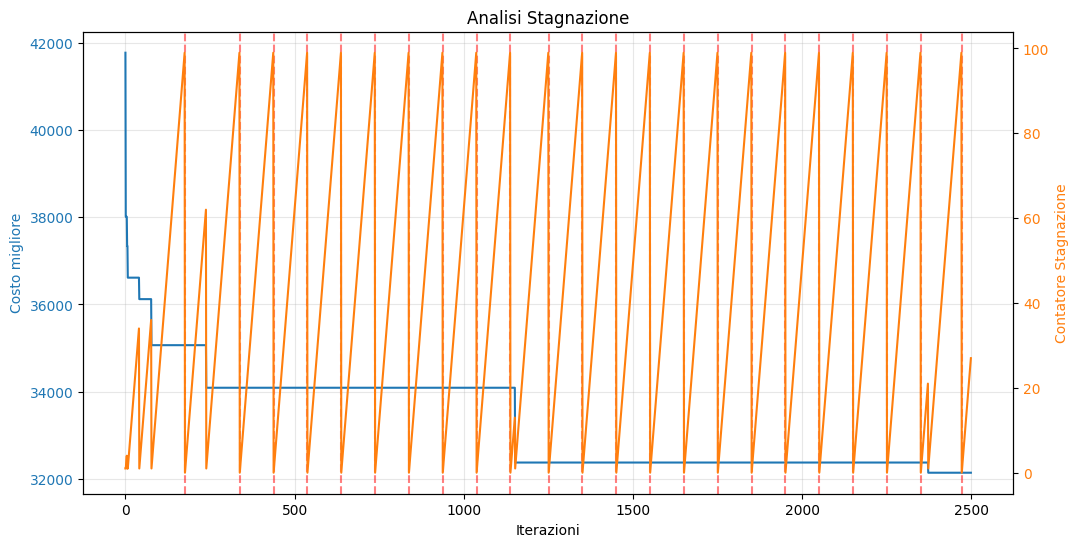

In [22]:
iterations = [x[0] for x in history]
costs = [x[1] for x in history]
stagnations = [x[2] for x in history]
restarts_idx = [x[0] for x in history if x[3] == 1]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Iterazioni')
ax1.set_ylabel('Costo migliore', color='tab:blue')
ax1.plot(iterations, costs, color='tab:blue', label='Costo migliore')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('Contatore Stagnazione', color='tab:orange')
ax2.plot(iterations, stagnations, color='tab:orange', label='Contatore Stagnazione')
ax2.tick_params(axis='y', labelcolor='tab:orange')

for r in restarts_idx:
    ax1.axvline(x=r, color='red', linestyle='--', alpha=0.5, label='Restart' if r == restarts_idx[0] else "")

plt.title(f"Analisi Stagnazione")
plt.show()

versione con decay=0.1

In [26]:
# MAIN
problem_instance = Problem(100, density=0.2, alpha=1, beta=1)
dist_matrix = precompute_distances(problem_instance)

aco = ACSMinMaxAntColonyOptimizerReset(
    problem_instance,
    dist_matrix,
    n_ants=30,
    n_iterations=3000,
    decay=0.1,
    alpha=1,
    beta=2,
    q0=0.0,
    stagnation_limit=100
)

sol, cost, history = aco.run()

print(f"\n---RISULTATO FINALE ACS Min-Max con Reset---")
print(f"Costo Migliore ACS: {cost:.2f}")
print(f"Baseline (Dijkstra): {problem_instance.baseline():.2f}")
if cost < problem_instance.baseline():
    print("VITTORIA: ACS ha battuto la baseline!")
else:
    print("SCONFITTA: ACS non è bastato (prova più iterazioni).")

Pre-calcolo delle distanze in corso...
Pre-calcolo delle distanze completato.
Inizio ACS Min-Max con 100 città, 30 formiche, 3000 iterazioni,q0=0.0, stagnation_limit=100:
Iterazione 1/3000, Costo migliore finora: 40115.12, Stagnazione: 1
Iterazione 21/3000, Costo migliore finora: 36060.55, Stagnazione: 15
Iterazione 41/3000, Costo migliore finora: 36060.55, Stagnazione: 35
Iterazione 61/3000, Costo migliore finora: 36060.55, Stagnazione: 55
Iterazione 81/3000, Costo migliore finora: 36060.55, Stagnazione: 75
Iterazione 101/3000, Costo migliore finora: 36060.55, Stagnazione: 95
Iterazione 121/3000, Costo migliore finora: 36041.84, Stagnazione: 16
Iterazione 141/3000, Costo migliore finora: 36041.84, Stagnazione: 36
Iterazione 161/3000, Costo migliore finora: 35440.30, Stagnazione: 5
Iterazione 181/3000, Costo migliore finora: 35440.30, Stagnazione: 25
Iterazione 201/3000, Costo migliore finora: 35440.30, Stagnazione: 45
Iterazione 221/3000, Costo migliore finora: 34746.42, Stagnazione: 

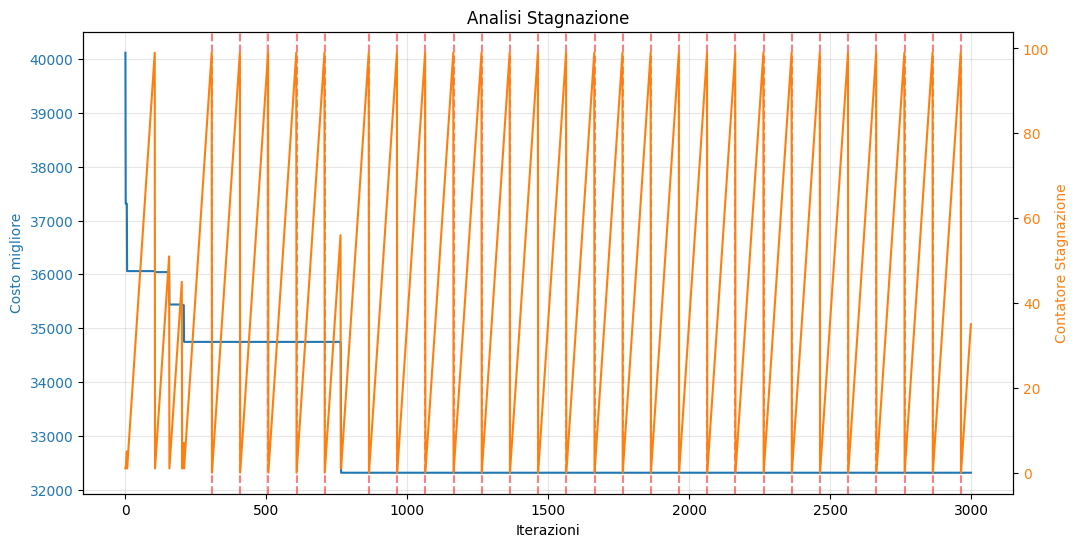

In [27]:
iterations = [x[0] for x in history]
costs = [x[1] for x in history]
stagnations = [x[2] for x in history]
restarts_idx = [x[0] for x in history if x[3] == 1]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Iterazioni')
ax1.set_ylabel('Costo migliore', color='tab:blue')
ax1.plot(iterations, costs, color='tab:blue', label='Costo migliore')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('Contatore Stagnazione', color='tab:orange')
ax2.plot(iterations, stagnations, color='tab:orange', label='Contatore Stagnazione')
ax2.tick_params(axis='y', labelcolor='tab:orange')

for r in restarts_idx:
    ax1.axvline(x=r, color='red', linestyle='--', alpha=0.5, label='Restart' if r == restarts_idx[0] else "")

plt.title(f"Analisi Stagnazione")
plt.show()